In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.3.0.dev20231206


2023-12-26 02:23:48,180	INFO worker.py:1538 -- Started a local Ray instance.


In [3]:
from secretflow.ml.nn.utils import BaseModule, TorchModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from torch import nn, optim

2023-12-26 02:23:52.876185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-26 02:23:54.823806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-26 02:23:54.823933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-26 02:23:54.823944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

使用的数据集： MNIST, CIFAR-10, CIFAR-100, EMNIST子集： EMNIST-L
使用的模型： 对 MNIST 和 EMNIST-L 使用具有 2 个隐藏层的全连接神经网络架构。 各层神经元数量分别为200和100；对于 CIFAR-10 和 CIFAR-100，我们使用 CNN 模型，由 2 个带有 64 个 5 × 5 滤波器的卷积层组成，后跟 2 个带有 394 和 192 个神经元的全连接层，以及一个 softmax 层。
下面使用的模型与原文模型略有不同。

In [4]:
class MNIST_Model(BaseModule):
    def __init__(self):
        super(MNIST_Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU()
        )
        self.head = nn.Linear(100, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x
    
class EMNISTL_Model(BaseModule):
    def __init__(self):
        super(EMNISTL_Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU()
        )
        self.head = nn.Linear(100, 26)

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [5]:
from typing import Dict, List, Tuple, Union
import numpy as np

from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU

def _convert_to_fedndarray(dataloader, parts, is_torch, num_classes_per_client, class_num):
    data_list = []
    label_list = []
    for data, label in dataloader:
        if is_torch:
            data = data.numpy()
            label = label.numpy()
        data_list.append(data)
        label_list.append(label)
    data_list, label_list = np.concatenate(data_list), np.concatenate(label_list)
    return create_ndarray(data_list, label_list, parts=parts, is_torch=is_torch, 
                          num_classes_per_client=num_classes_per_client, class_num=class_num)

def create_ndarray(data, labels, parts, is_torch=False, num_classes_per_client=4, class_num=10): # class_num 为数据集的分类类别数
    assert len(data) == len(labels), "Data and labels must have the same length"
    class_indices = {i: np.where(labels == i + min(labels))[0] for i in range(class_num)}
    # 分配给每个 PYU 的类别
    pyu_classes = {}
    total_samples = len(data)
    for idx, pyu in enumerate(parts.keys()):
        np.random.seed(idx)
        pyu_classes[pyu] = np.random.choice(class_num, num_classes_per_client, replace=False)

    # 分配数据和标签给每个 PYU
    pyu_data = {}
    pyu_labels = {}
    for pyu, proportion in parts.items():
        pyu_sample_size = int(total_samples * proportion)  # 计算每个 PYU 的样本量
        # 为每个 PYU 从选定的类别中采样数据
        indices = np.concatenate(
            [np.random.choice(class_indices[cls], size=pyu_sample_size // num_classes_per_client, replace=True) for cls
             in pyu_classes[pyu]])
        np.random.shuffle(indices)  # 打乱索引
        pyu_data[pyu] = data[indices]
        pyu_labels[pyu] = labels[indices]
        print(len(pyu_data[pyu]), pyu_classes[pyu],pyu_labels[pyu][0])  # 打印每个PYU的数据量和随机类别

    # 将数据和标签转换为 FedNdarray
    data_fedndarray = FedNdarray(
        partitions={
            pyu: pyu(lambda arr: arr)(pyu_data[pyu]) for pyu in parts.keys()
        },
        partition_way=PartitionWay.HORIZONTAL,
    )
    labels_fedndarray = FedNdarray(
        partitions={
            pyu: pyu(lambda arr: arr)(pyu_labels[pyu]) for pyu in parts.keys()
        },
        partition_way=PartitionWay.HORIZONTAL,
    )

    return data_fedndarray, labels_fedndarray

In [6]:
from torchvision.datasets import MNIST, EMNIST, CIFAR10, CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader

def load_mnist( # 共有 70000 张， 10 类，60000个训练样本和10000个测试样本
        parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
        batch_size: int = 1,
        is_torch: bool = True,
        num_classes_per_client=4,
        class_num=10,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    """Load MNIST dataset to federated ndarrays.

    Args:
        parts: the data partitions.
        batch_size: Batch size for the DataLoader.
        is_torch: optional, return torch tensors if True. Default to True.
        num_classes_per_client: the random classes number of per client.
        class_num: the number of dataset categories
        
    Returns:
        A tuple consists of two tuples, (x_train, y_train) and (x_test, y_test).
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # 加载 EMNIST 训练集和测试集
    trainset = MNIST(root='./data', train=True, download=True, transform=transform)
    testset = MNIST(root='./data', train=False, download=True, transform=transform)
    # EMNIST 数据集主要分为6类：By_Class, By_Merge, Balanced, Digits, Letters, MNIST，其中 MNIST 部分数据较少，共70000张10个子类数据
    # 这里使用的是 EMNIST 数据集中的MNIST部分，原论文未对数据集细节进行描述，大概率是使用的整个EMNIST数据集，因此准确率会较低

    # 使用 DataLoader 进行批处理
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # 将 DataLoader 转换为 SecretFlow 可处理的格式
    # 注意: 这里需要根据 SecretFlow 的要求进行适当的转换
    train_data, train_labels = _convert_to_fedndarray(trainloader, parts, is_torch, num_classes_per_client, class_num)
    test_data, test_labels = _convert_to_fedndarray(testloader, parts, is_torch, num_classes_per_client, class_num)

    return ((train_data, train_labels), (test_data, test_labels))

def load_emnist_L( # 共 103600 张，37 类，每一类包含相同数据，每一类训练集 2400 张，测试集 400 张
        parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
        batch_size: int = 1,
        is_torch: bool = True,
        num_classes_per_client=4,
        class_num=26,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    """Load EMNIST dataset to federated ndarrays.

    Args:
        parts: the data partitions.
        batch_size: Batch size for the DataLoader.
        is_torch: optional, return torch tensors if True. Default to True.
        num_classes_per_client: the random classes number of per client.
        class_num: the number of dataset categories

    Returns:
        A tuple consists of two tuples, (x_train, y_train) and (x_test, y_test).
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # 加载 EMNIST 训练集和测试集
    trainset = EMNIST(root='./data', train=True, split='letters', download=True, transform=transform)
    testset = EMNIST(root='./data', train=False, split='letters', download=True, transform=transform)
    # EMNIST 数据集主要分为6类：By_Class, By_Merge, Balanced, Digits, Letters, MNIST

    # 使用 DataLoader 进行批处理
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # 将 DataLoader 转换为 SecretFlow 可处理的格式
    # 注意: 这里需要根据 SecretFlow 的要求进行适当的转换
    train_data, train_labels = _convert_to_fedndarray(trainloader, parts, is_torch, num_classes_per_client, class_num)
    test_data, test_labels = _convert_to_fedndarray(testloader, parts, is_torch, num_classes_per_client, class_num)

    return ((train_data, train_labels), (test_data, test_labels))

## 在这里修改要使用的数据集

In [7]:
load_data = {0:load_mnist, 1:load_emnist_L}
model = {0:MNIST_Model, 1:EMNISTL_Model}
num_classes = {0:10, 1:26}
# i = 0 # 使用 MNIST
i = 1 # 使用 EMNIST-L
(train_data, train_label), (test_data, test_label) = load_data[i](
    parts={alice: 0.1, bob: 0.1},
    is_torch=True,
)

12480 [ 2 20 14 17] 18
12480 [18 13 17  3] 4
2080 [ 2 20 14 17] 21
2080 [18 13 17  3] 18


In [8]:
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.SGD, lr=0.01)
model_def = TorchModel(
    model_fn=model[i],
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=num_classes[i], average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=num_classes[i], average='micro'),
    ],
)
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.


In [9]:
# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_dyn',
    backend="torch",
)
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=10,
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_dyn.PYUFedDYN'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_dyn.PYUFedDYN'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42f94580>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42fb0a90>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42fb0ca0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f3031311eb0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42fb0d60>, PYUR

Epoch 1/20


Train Processing: :  92%|█████████▏| 90/98 [00:36<00:02,  2.77it/s]/home/cyf/anaconda3/envs/secretflow/lib/python3.8/site-packages/secretflow/ml/nn/metrics.py:59: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
2023-12-26 02:29:03.409956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-12-26 02:29:03.410044: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Train Processing: :  92%|█████████▏| 90/98 [00:40<00:03,  2.22it/s, {'multiclassaccuracy': 0.2617

(PYUFedDYN pid=2240451) {'train-loss': 3.794959545135498, 'train_multiclassaccuracy': tensor(0.2873), 'train_multiclassprecision': tensor(0.2873), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/20
(PYUFedDYN pid=2240517) {'train-loss': 4.745523452758789, 'train_multiclassaccuracy': tensor(0.2362), 'train_multiclassprecision': tensor(0.2362), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3/20
(PYUFedDYN pid=2240451) {'train-loss': 2.512716054916382, 'train_multiclassaccuracy': tensor(0.2974), 'train_multiclassprecision': tensor(0.2974), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}
(PYUFedDYN pid=2240517) {'train-loss': 2.5623252391815186, 'train_multiclassaccuracy': tensor(0.2855), 'train_multiclassprecision': tensor(0.2855), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}


Train Processing: :  92%|█████████▏| 90/98 [00:39<00:03,  2.29it/s, {'multiclassaccuracy': 0.39635417, 'multiclassprecision': 0.39635417, 'val_multiclassaccuracy': 0.25048077, 'val_multiclassprecision': 0.25048077}]


(PYUFedDYN pid=2240451) {'train-loss': 2.0767440795898438, 'train_multiclassaccuracy': tensor(0.4011), 'train_multiclassprecision': tensor(0.4011), 'val_eval_multiclassaccuracy': tensor(0.2510), 'val_eval_multiclassprecision': tensor(0.2510)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4/20
(PYUFedDYN pid=2240517) {'train-loss': 2.1670150756835938, 'train_multiclassaccuracy': tensor(0.3916), 'train_multiclassprecision': tensor(0.3916), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5/20
(PYUFedDYN pid=2240451) {'train-loss': 2.075655698776245, 'train_multiclassaccuracy': tensor(0.4946), 'train_multiclassprecision': tensor(0.4946), 'val_eval_multiclassaccuracy': tensor(0.3596), 'val_eval_multiclassprecision': tensor(0.3596)}
(PYUFedDYN pid=2240517) {'train-loss': 2.0732345581054688, 'train_multiclassaccuracy': tensor(0.5119), 'train_multiclassprecision': tensor(0.5119), 'val_eval_multiclassaccuracy': tensor(0.4409), 'val_eval_multiclassprecision': tensor(0.4409)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6/20
(PYUFedDYN pid=2240451) {'train-loss': 2.032959461212158, 'train_multiclassaccuracy': tensor(0.5863), 'train_multiclassprecision': tensor(0.5863), 'val_eval_multiclassaccuracy': tensor(0.5957), 'val_eval_multiclassprecision': tensor(0.5957)}
(PYUFedDYN pid=2240517) {'train-loss': 1.89757239818573, 'train_multiclassaccuracy': tensor(0.6130), 'train_multiclassprecision': tensor(0.6130), 'val_eval_multiclassaccuracy': tensor(0.6096), 'val_eval_multiclassprecision': tensor(0.6096)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7/20
(PYUFedDYN pid=2240451) {'train-loss': 1.9244282245635986, 'train_multiclassaccuracy': tensor(0.6942), 'train_multiclassprecision': tensor(0.6942), 'val_eval_multiclassaccuracy': tensor(0.7188), 'val_eval_multiclassprecision': tensor(0.7188)}
(PYUFedDYN pid=2240517) {'train-loss': 1.6751306056976318, 'train_multiclassaccuracy': tensor(0.6812), 'train_multiclassprecision': tensor(0.6812), 'val_eval_multiclassaccuracy': tensor(0.6380), 'val_eval_multiclassprecision': tensor(0.6380)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8/20
(PYUFedDYN pid=2240451) {'train-loss': 1.830076813697815, 'train_multiclassaccuracy': tensor(0.7706), 'train_multiclassprecision': tensor(0.7706), 'val_eval_multiclassaccuracy': tensor(0.7808), 'val_eval_multiclassprecision': tensor(0.7808)}
(PYUFedDYN pid=2240517) {'train-loss': 1.4427299499511719, 'train_multiclassaccuracy': tensor(0.7417), 'train_multiclassprecision': tensor(0.7417), 'val_eval_multiclassaccuracy': tensor(0.6678), 'val_eval_multiclassprecision': tensor(0.6678)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9/20
(PYUFedDYN pid=2240451) {'train-loss': 1.605041742324829, 'train_multiclassaccuracy': tensor(0.8229), 'train_multiclassprecision': tensor(0.8229), 'val_eval_multiclassaccuracy': tensor(0.8062), 'val_eval_multiclassprecision': tensor(0.8062)}
(PYUFedDYN pid=2240517) {'train-loss': 1.18393874168396, 'train_multiclassaccuracy': tensor(0.7851), 'train_multiclassprecision': tensor(0.7851), 'val_eval_multiclassaccuracy': tensor(0.6995), 'val_eval_multiclassprecision': tensor(0.6995)}


Train Processing: :  92%|█████████▏| 90/98 [00:42<00:03,  2.11it/s, {'multiclassaccuracy': 0.83633816, 'multiclassprecision': 0.83633816, 'val_multiclassaccuracy': 0.77572113, 'val_multiclassprecision': 0.77572113}]


(PYUFedDYN pid=2240451) {'train-loss': 1.2386958599090576, 'train_multiclassaccuracy': tensor(0.8538), 'train_multiclassprecision': tensor(0.8538), 'val_eval_multiclassaccuracy': tensor(0.8236), 'val_eval_multiclassprecision': tensor(0.8236)}
(PYUFedDYN pid=2240517) {'train-loss': 0.939348042011261, 'train_multiclassaccuracy': tensor(0.8189), 'train_multiclassprecision': tensor(0.8189), 'val_eval_multiclassaccuracy': tensor(0.7279), 'val_eval_multiclassprecision': tensor(0.7279)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10/20


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11/20
(PYUFedDYN pid=2240451) {'train-loss': 0.8955532908439636, 'train_multiclassaccuracy': tensor(0.8700), 'train_multiclassprecision': tensor(0.8700), 'val_eval_multiclassaccuracy': tensor(0.8351), 'val_eval_multiclassprecision': tensor(0.8351)}
(PYUFedDYN pid=2240517) {'train-loss': 0.7381981611251831, 'train_multiclassaccuracy': tensor(0.8368), 'train_multiclassprecision': tensor(0.8368), 'val_eval_multiclassaccuracy': tensor(0.7490), 'val_eval_multiclassprecision': tensor(0.7490)}


Train Processing: :  92%|█████████▏| 90/98 [00:41<00:03,  2.17it/s, {'multiclassaccuracy': 0.86470354, 'multiclassprecision': 0.86470354, 'val_multiclassaccuracy': 0.7997596, 'val_multiclassprecision': 0.7997596}]


(PYUFedDYN pid=2240451) {'train-loss': 0.6246516704559326, 'train_multiclassaccuracy': tensor(0.8812), 'train_multiclassprecision': tensor(0.8812), 'val_eval_multiclassaccuracy': tensor(0.8428), 'val_eval_multiclassprecision': tensor(0.8428)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12/20
(PYUFedDYN pid=2240517) {'train-loss': 0.5806959271430969, 'train_multiclassaccuracy': tensor(0.8482), 'train_multiclassprecision': tensor(0.8482), 'val_eval_multiclassaccuracy': tensor(0.7567), 'val_eval_multiclassprecision': tensor(0.7567)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13/20
(PYUFedDYN pid=2240451) {'train-loss': 0.41548609733581543, 'train_multiclassaccuracy': tensor(0.8877), 'train_multiclassprecision': tensor(0.8877), 'val_eval_multiclassaccuracy': tensor(0.8457), 'val_eval_multiclassprecision': tensor(0.8457)}
(PYUFedDYN pid=2240517) {'train-loss': 0.45794543623924255, 'train_multiclassaccuracy': tensor(0.8574), 'train_multiclassprecision': tensor(0.8574), 'val_eval_multiclassaccuracy': tensor(0.7712), 'val_eval_multiclassprecision': tensor(0.7712)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14/20
(PYUFedDYN pid=2240451) {'train-loss': 0.2454618662595749, 'train_multiclassaccuracy': tensor(0.8927), 'train_multiclassprecision': tensor(0.8927), 'val_eval_multiclassaccuracy': tensor(0.8500), 'val_eval_multiclassprecision': tensor(0.8500)}
(PYUFedDYN pid=2240517) {'train-loss': 0.3586876690387726, 'train_multiclassaccuracy': tensor(0.8634), 'train_multiclassprecision': tensor(0.8634), 'val_eval_multiclassaccuracy': tensor(0.7822), 'val_eval_multiclassprecision': tensor(0.7822)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15/20
(PYUFedDYN pid=2240451) {'train-loss': 0.10278697311878204, 'train_multiclassaccuracy': tensor(0.8970), 'train_multiclassprecision': tensor(0.8970), 'val_eval_multiclassaccuracy': tensor(0.8538), 'val_eval_multiclassprecision': tensor(0.8538)}
(PYUFedDYN pid=2240517) {'train-loss': 0.27769675850868225, 'train_multiclassaccuracy': tensor(0.8691), 'train_multiclassprecision': tensor(0.8691), 'val_eval_multiclassaccuracy': tensor(0.7889), 'val_eval_multiclassprecision': tensor(0.7889)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

(PYUFedDYN pid=2240451) {'train-loss': -0.020406024530529976, 'train_multiclassaccuracy': tensor(0.9003), 'train_multiclassprecision': tensor(0.9003), 'val_eval_multiclassaccuracy': tensor(0.8558), 'val_eval_multiclassprecision': tensor(0.8558)}
Epoch 16/20
(PYUFedDYN pid=2240517) {'train-loss': 0.20450250804424286, 'train_multiclassaccuracy': tensor(0.8736), 'train_multiclassprecision': tensor(0.8736), 'val_eval_multiclassaccuracy': tensor(0.7880), 'val_eval_multiclassprecision': tensor(0.7880)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17/20
(PYUFedDYN pid=2240451) {'train-loss': -0.13350263237953186, 'train_multiclassaccuracy': tensor(0.9021), 'train_multiclassprecision': tensor(0.9021), 'val_eval_multiclassaccuracy': tensor(0.8606), 'val_eval_multiclassprecision': tensor(0.8606)}
(PYUFedDYN pid=2240517) {'train-loss': 0.1362878531217575, 'train_multiclassaccuracy': tensor(0.8771), 'train_multiclassprecision': tensor(0.8771), 'val_eval_multiclassaccuracy': tensor(0.7909), 'val_eval_multiclassprecision': tensor(0.7909)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18/20
(PYUFedDYN pid=2240451) {'train-loss': -0.23322425782680511, 'train_multiclassaccuracy': tensor(0.9039), 'train_multiclassprecision': tensor(0.9039), 'val_eval_multiclassaccuracy': tensor(0.8620), 'val_eval_multiclassprecision': tensor(0.8620)}
(PYUFedDYN pid=2240517) {'train-loss': 0.06517574936151505, 'train_multiclassaccuracy': tensor(0.8806), 'train_multiclassprecision': tensor(0.8806), 'val_eval_multiclassaccuracy': tensor(0.7962), 'val_eval_multiclassprecision': tensor(0.7962)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19/20
(PYUFedDYN pid=2240451) {'train-loss': -0.32694005966186523, 'train_multiclassaccuracy': tensor(0.9062), 'train_multiclassprecision': tensor(0.9062), 'val_eval_multiclassaccuracy': tensor(0.8654), 'val_eval_multiclassprecision': tensor(0.8654)}
(PYUFedDYN pid=2240517) {'train-loss': -0.0060754683800041676, 'train_multiclassaccuracy': tensor(0.8824), 'train_multiclassprecision': tensor(0.8824), 'val_eval_multiclassaccuracy': tensor(0.7986), 'val_eval_multiclassprecision': tensor(0.7986)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20/20
(PYUFedDYN pid=2240451) {'train-loss': -0.41389429569244385, 'train_multiclassaccuracy': tensor(0.9079), 'train_multiclassprecision': tensor(0.9079), 'val_eval_multiclassaccuracy': tensor(0.8692), 'val_eval_multiclassprecision': tensor(0.8692)}
(PYUFedDYN pid=2240517) {'train-loss': -0.07672053575515747, 'train_multiclassaccuracy': tensor(0.8845), 'train_multiclassprecision': tensor(0.8845), 'val_eval_multiclassaccuracy': tensor(0.8010), 'val_eval_multiclassprecision': tensor(0.8010)}


Train Processing: :  92%|█████████▏| 90/98 [00:29<00:02,  3.02it/s, {'multiclassaccuracy': 0.8980769, 'multiclassprecision': 0.8980769, 'val_multiclassaccuracy': 0.8403846, 'val_multiclassprecision': 0.8403846}]


(PYUFedDYN pid=2240451) {'train-loss': -0.4960310459136963, 'train_multiclassaccuracy': tensor(0.9099), 'train_multiclassprecision': tensor(0.9099), 'val_eval_multiclassaccuracy': tensor(0.8740), 'val_eval_multiclassprecision': tensor(0.8740)}
(PYUFedDYN pid=2240517) {'train-loss': -0.1542942374944687, 'train_multiclassaccuracy': tensor(0.8863), 'train_multiclassprecision': tensor(0.8863), 'val_eval_multiclassaccuracy': tensor(0.8067), 'val_eval_multiclassprecision': tensor(0.8067)}


In [10]:
print(history['local_history'])

{'alice_train-loss': [3.794959545135498, 2.512716054916382, 2.0767440795898438, 2.075655698776245, 2.032959461212158, 1.9244282245635986, 1.830076813697815, 1.605041742324829, 1.2386958599090576, 0.8955532908439636, 0.6246516704559326, 0.41548609733581543, 0.2454618662595749, 0.10278697311878204, -0.020406024530529976, -0.13350263237953186, -0.23322425782680511, -0.32694005966186523, -0.41389429569244385, -0.4960310459136963], 'alice_train_multiclassaccuracy': [tensor(0.2873), tensor(0.2974), tensor(0.4011), tensor(0.4946), tensor(0.5863), tensor(0.6942), tensor(0.7706), tensor(0.8229), tensor(0.8538), tensor(0.8700), tensor(0.8812), tensor(0.8877), tensor(0.8927), tensor(0.8970), tensor(0.9003), tensor(0.9021), tensor(0.9039), tensor(0.9062), tensor(0.9079), tensor(0.9099)], 'alice_train_multiclassprecision': [tensor(0.2873), tensor(0.2974), tensor(0.4011), tensor(0.4946), tensor(0.5863), tensor(0.6942), tensor(0.7706), tensor(0.8229), tensor(0.8538), tensor(0.8700), tensor(0.8812), t

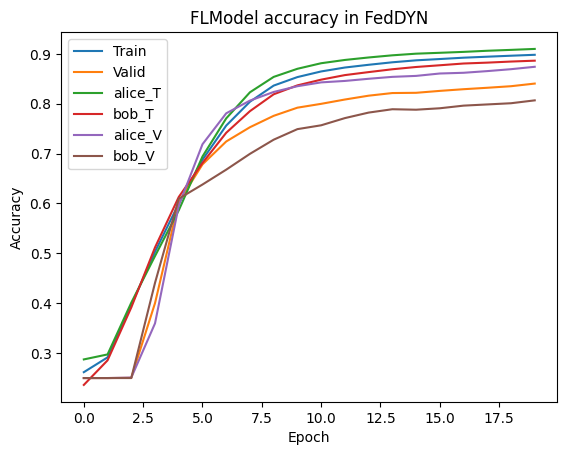

In [11]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history['global_history']['multiclassaccuracy'])
plt.plot(history['global_history']['val_multiclassaccuracy'])
plt.plot(history['local_history']['alice_train_multiclassaccuracy'])
plt.plot(history['local_history']['bob_train_multiclassaccuracy'])
plt.plot(history['local_history']['alice_val_eval_multiclassaccuracy'])
plt.plot(history['local_history']['bob_val_eval_multiclassaccuracy'])
plt.title('FLModel accuracy in FedDYN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid','alice_T','bob_T','alice_V','bob_V'], loc='upper left')
plt.show()

In [12]:
fl_model_2 = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)
history_2 = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=10,
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42f94580>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42fb0a90>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42fb0ca0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f3031311eb0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2f42fb0d60>

Epoch 1/20


Train Processing: :  51%|█████     | 50/98 [00:14<00:12,  3.85it/s](pid=2249886) 2023-12-26 02:41:02.520471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(pid=2249886) 2023-12-26 02:41:02.520564: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(pid=2249886) 2023-12-26 02:41:02.520573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Train Processing: :  92%|█████████▏| 90/98 [00:20<00:01,  5.29it/s]/home/cyf/anaconda3/envs/secretflow/lib/python3.8/site-packages

Epoch 2/20
(PYUFedDYN pid=2240451) {'train-loss': -0.5729689598083496, 'train_multiclassaccuracy': tensor(0.9107), 'train_multiclassprecision': tensor(0.9107), 'val_eval_multiclassaccuracy': tensor(0.8798), 'val_eval_multiclassprecision': tensor(0.8798)}
(PYUFedDYN pid=2240517) {'train-loss': -0.24142688512802124, 'train_multiclassaccuracy': tensor(0.8890), 'train_multiclassprecision': tensor(0.8890), 'val_eval_multiclassaccuracy': tensor(0.8077), 'val_eval_multiclassprecision': tensor(0.8077)}


(pid=2249951) 2023-12-26 02:41:19.410783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(pid=2249951) 2023-12-26 02:41:19.410872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(pid=2249951) 2023-12-26 02:41:19.410881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3/20
(PYUFedDYN pid=2240451) {'train-loss': -0.6594232320785522, 'train_multiclassaccuracy': tensor(0.9119), 'train_multiclassprecision': tensor(0.9119), 'val_eval_multiclassaccuracy': tensor(0.8788), 'val_eval_multiclassprecision': tensor(0.8788)}
(PYUFedDYN pid=2240517) {'train-loss': -0.31832805275917053, 'train_multiclassaccuracy': tensor(0.8913), 'train_multiclassprecision': tensor(0.8913), 'val_eval_multiclassaccuracy': tensor(0.8091), 'val_eval_multiclassprecision': tensor(0.8091)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4/20
(PYUFedDYN pid=2240451) {'train-loss': -0.7391104102134705, 'train_multiclassaccuracy': tensor(0.9124), 'train_multiclassprecision': tensor(0.9124), 'val_eval_multiclassaccuracy': tensor(0.8784), 'val_eval_multiclassprecision': tensor(0.8784)}
(PYUFedDYN pid=2240517) {'train-loss': -0.40349987149238586, 'train_multiclassaccuracy': tensor(0.8929), 'train_multiclassprecision': tensor(0.8929), 'val_eval_multiclassaccuracy': tensor(0.8115), 'val_eval_multiclassprecision': tensor(0.8115)}


Train Processing: :  92%|█████████▏| 90/98 [00:31<00:02,  2.84it/s, {'multiclassaccuracy': 0.90436697, 'multiclassprecision': 0.90436697, 'val_multiclassaccuracy': 0.8473558, 'val_multiclassprecision': 0.8473558}]


(PYUFedDYN pid=2240451) {'train-loss': -0.8208961486816406, 'train_multiclassaccuracy': tensor(0.9131), 'train_multiclassprecision': tensor(0.9131), 'val_eval_multiclassaccuracy': tensor(0.8813), 'val_eval_multiclassprecision': tensor(0.8813)}
(PYUFedDYN pid=2240451) 
(PYUFedDYN pid=2240517) {'train-loss': -0.4857953190803528, 'train_multiclassaccuracy': tensor(0.8957), 'train_multiclassprecision': tensor(0.8957), 'val_eval_multiclassaccuracy': tensor(0.8135), 'val_eval_multiclassprecision': tensor(0.8135)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5/20
(PYUFedDYN pid=2240517) 


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6/20
(PYUFedDYN pid=2240451) {'train-loss': -0.9049100875854492, 'train_multiclassaccuracy': tensor(0.9139), 'train_multiclassprecision': tensor(0.9139), 'val_eval_multiclassaccuracy': tensor(0.8837), 'val_eval_multiclassprecision': tensor(0.8837)}
(PYUFedDYN pid=2240517) {'train-loss': -0.5795552134513855, 'train_multiclassaccuracy': tensor(0.8967), 'train_multiclassprecision': tensor(0.8967), 'val_eval_multiclassaccuracy': tensor(0.8130), 'val_eval_multiclassprecision': tensor(0.8130)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7/20
(PYUFedDYN pid=2240451) {'train-loss': -0.9857649207115173, 'train_multiclassaccuracy': tensor(0.9139), 'train_multiclassprecision': tensor(0.9139), 'val_eval_multiclassaccuracy': tensor(0.8851), 'val_eval_multiclassprecision': tensor(0.8851)}
(PYUFedDYN pid=2240517) {'train-loss': -0.6570270657539368, 'train_multiclassaccuracy': tensor(0.8982), 'train_multiclassprecision': tensor(0.8982), 'val_eval_multiclassaccuracy': tensor(0.8135), 'val_eval_multiclassprecision': tensor(0.8135)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8/20
(PYUFedDYN pid=2240451) {'train-loss': -1.0810891389846802, 'train_multiclassaccuracy': tensor(0.9142), 'train_multiclassprecision': tensor(0.9142), 'val_eval_multiclassaccuracy': tensor(0.8865), 'val_eval_multiclassprecision': tensor(0.8865)}
(PYUFedDYN pid=2240517) {'train-loss': -0.7449828386306763, 'train_multiclassaccuracy': tensor(0.8990), 'train_multiclassprecision': tensor(0.8990), 'val_eval_multiclassaccuracy': tensor(0.8130), 'val_eval_multiclassprecision': tensor(0.8130)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9/20
(PYUFedDYN pid=2240451) {'train-loss': -1.1536775827407837, 'train_multiclassaccuracy': tensor(0.9143), 'train_multiclassprecision': tensor(0.9143), 'val_eval_multiclassaccuracy': tensor(0.8885), 'val_eval_multiclassprecision': tensor(0.8885)}
(PYUFedDYN pid=2240517) {'train-loss': -0.8344694972038269, 'train_multiclassaccuracy': tensor(0.8995), 'train_multiclassprecision': tensor(0.8995), 'val_eval_multiclassaccuracy': tensor(0.8101), 'val_eval_multiclassprecision': tensor(0.8101)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10/20
(PYUFedDYN pid=2240451) {'train-loss': -1.2498149871826172, 'train_multiclassaccuracy': tensor(0.9139), 'train_multiclassprecision': tensor(0.9139), 'val_eval_multiclassaccuracy': tensor(0.8875), 'val_eval_multiclassprecision': tensor(0.8875)}
(PYUFedDYN pid=2240517) {'train-loss': -0.9254679679870605, 'train_multiclassaccuracy': tensor(0.9008), 'train_multiclassprecision': tensor(0.9008), 'val_eval_multiclassaccuracy': tensor(0.8120), 'val_eval_multiclassprecision': tensor(0.8120)}


Train Processing: :  92%|█████████▏| 90/98 [00:29<00:02,  3.08it/s, {'multiclassaccuracy': 0.90757215, 'multiclassprecision': 0.90757215, 'val_multiclassaccuracy': 0.8504808, 'val_multiclassprecision': 0.8504808}]


(PYUFedDYN pid=2240451) {'train-loss': -1.3439548015594482, 'train_multiclassaccuracy': tensor(0.9139), 'train_multiclassprecision': tensor(0.9139), 'val_eval_multiclassaccuracy': tensor(0.8880), 'val_eval_multiclassprecision': tensor(0.8880)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11/20
(PYUFedDYN pid=2240517) {'train-loss': -1.0157570838928223, 'train_multiclassaccuracy': tensor(0.9013), 'train_multiclassprecision': tensor(0.9013), 'val_eval_multiclassaccuracy': tensor(0.8130), 'val_eval_multiclassprecision': tensor(0.8130)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12/20
(PYUFedDYN pid=2240451) {'train-loss': -1.4356552362442017, 'train_multiclassaccuracy': tensor(0.9150), 'train_multiclassprecision': tensor(0.9150), 'val_eval_multiclassaccuracy': tensor(0.8889), 'val_eval_multiclassprecision': tensor(0.8889)}
(PYUFedDYN pid=2240517) {'train-loss': -1.1214447021484375, 'train_multiclassaccuracy': tensor(0.9009), 'train_multiclassprecision': tensor(0.9009), 'val_eval_multiclassaccuracy': tensor(0.8135), 'val_eval_multiclassprecision': tensor(0.8135)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13/20
(PYUFedDYN pid=2240451) {'train-loss': -1.536663293838501, 'train_multiclassaccuracy': tensor(0.9147), 'train_multiclassprecision': tensor(0.9147), 'val_eval_multiclassaccuracy': tensor(0.8899), 'val_eval_multiclassprecision': tensor(0.8899)}
(PYUFedDYN pid=2240517) {'train-loss': -1.215333104133606, 'train_multiclassaccuracy': tensor(0.9010), 'train_multiclassprecision': tensor(0.9010), 'val_eval_multiclassaccuracy': tensor(0.8149), 'val_eval_multiclassprecision': tensor(0.8149)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14/20
(PYUFedDYN pid=2240451) {'train-loss': -1.6438186168670654, 'train_multiclassaccuracy': tensor(0.9151), 'train_multiclassprecision': tensor(0.9151), 'val_eval_multiclassaccuracy': tensor(0.8904), 'val_eval_multiclassprecision': tensor(0.8904)}
(PYUFedDYN pid=2240517) {'train-loss': -1.3206884860992432, 'train_multiclassaccuracy': tensor(0.9016), 'train_multiclassprecision': tensor(0.9016), 'val_eval_multiclassaccuracy': tensor(0.8173), 'val_eval_multiclassprecision': tensor(0.8173)}


Train Processing: :  92%|█████████▏| 90/98 [00:31<00:02,  2.83it/s, {'multiclassaccuracy': 0.9091747, 'multiclassprecision': 0.9091747, 'val_multiclassaccuracy': 0.8545673, 'val_multiclassprecision': 0.8545673}]


(PYUFedDYN pid=2240451) {'train-loss': -1.7403758764266968, 'train_multiclassaccuracy': tensor(0.9162), 'train_multiclassprecision': tensor(0.9162), 'val_eval_multiclassaccuracy': tensor(0.8928), 'val_eval_multiclassprecision': tensor(0.8928)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

(PYUFedDYN pid=2240517) {'train-loss': -1.4218271970748901, 'train_multiclassaccuracy': tensor(0.9022), 'train_multiclassprecision': tensor(0.9022), 'val_eval_multiclassaccuracy': tensor(0.8163), 'val_eval_multiclassprecision': tensor(0.8163)}
Epoch 15/20


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16/20
(PYUFedDYN pid=2240451) {'train-loss': -1.854453206062317, 'train_multiclassaccuracy': tensor(0.9161), 'train_multiclassprecision': tensor(0.9161), 'val_eval_multiclassaccuracy': tensor(0.8933), 'val_eval_multiclassprecision': tensor(0.8933)}
(PYUFedDYN pid=2240517) {'train-loss': -1.518033742904663, 'train_multiclassaccuracy': tensor(0.9022), 'train_multiclassprecision': tensor(0.9022), 'val_eval_multiclassaccuracy': tensor(0.8183), 'val_eval_multiclassprecision': tensor(0.8183)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17/20
(PYUFedDYN pid=2240451) {'train-loss': -1.9623757600784302, 'train_multiclassaccuracy': tensor(0.9163), 'train_multiclassprecision': tensor(0.9163), 'val_eval_multiclassaccuracy': tensor(0.8942), 'val_eval_multiclassprecision': tensor(0.8942)}
(PYUFedDYN pid=2240517) {'train-loss': -1.6337538957595825, 'train_multiclassaccuracy': tensor(0.9025), 'train_multiclassprecision': tensor(0.9025), 'val_eval_multiclassaccuracy': tensor(0.8173), 'val_eval_multiclassprecision': tensor(0.8173)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18/20
(PYUFedDYN pid=2240451) {'train-loss': -2.0633158683776855, 'train_multiclassaccuracy': tensor(0.9164), 'train_multiclassprecision': tensor(0.9164), 'val_eval_multiclassaccuracy': tensor(0.8933), 'val_eval_multiclassprecision': tensor(0.8933)}
(PYUFedDYN pid=2240517) {'train-loss': -1.7393596172332764, 'train_multiclassaccuracy': tensor(0.9023), 'train_multiclassprecision': tensor(0.9023), 'val_eval_multiclassaccuracy': tensor(0.8212), 'val_eval_multiclassprecision': tensor(0.8212)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19/20
(PYUFedDYN pid=2240451) {'train-loss': -2.1843044757843018, 'train_multiclassaccuracy': tensor(0.9163), 'train_multiclassprecision': tensor(0.9163), 'val_eval_multiclassaccuracy': tensor(0.8923), 'val_eval_multiclassprecision': tensor(0.8923)}
(PYUFedDYN pid=2240517) {'train-loss': -1.8467469215393066, 'train_multiclassaccuracy': tensor(0.9026), 'train_multiclassprecision': tensor(0.9026), 'val_eval_multiclassaccuracy': tensor(0.8240), 'val_eval_multiclassprecision': tensor(0.8240)}


Train Processing: :   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20/20
(PYUFedDYN pid=2240451) {'train-loss': -2.315540075302124, 'train_multiclassaccuracy': tensor(0.9161), 'train_multiclassprecision': tensor(0.9161), 'val_eval_multiclassaccuracy': tensor(0.8923), 'val_eval_multiclassprecision': tensor(0.8923)}
(PYUFedDYN pid=2240517) {'train-loss': -1.9503947496414185, 'train_multiclassaccuracy': tensor(0.9032), 'train_multiclassprecision': tensor(0.9032), 'val_eval_multiclassaccuracy': tensor(0.8240), 'val_eval_multiclassprecision': tensor(0.8240)}


Train Processing: :  92%|█████████▏| 90/98 [00:23<00:02,  3.87it/s, {'multiclassaccuracy': 0.9098558, 'multiclassprecision': 0.9098558, 'val_multiclassaccuracy': 0.8560096, 'val_multiclassprecision': 0.8560096}]


In [13]:
print(history_2['local_history'])

(PYUFedDYN pid=2240451) {'train-loss': -2.4477920532226562, 'train_multiclassaccuracy': tensor(0.9159), 'train_multiclassprecision': tensor(0.9159), 'val_eval_multiclassaccuracy': tensor(0.8918), 'val_eval_multiclassprecision': tensor(0.8918)}
(PYUFedDYN pid=2240517) {'train-loss': -2.059412717819214, 'train_multiclassaccuracy': tensor(0.9038), 'train_multiclassprecision': tensor(0.9038), 'val_eval_multiclassaccuracy': tensor(0.8202), 'val_eval_multiclassprecision': tensor(0.8202)}
{'alice_train-loss': [-0.5729689598083496, -0.6594232320785522, -0.7391104102134705, -0.8208961486816406, -0.9049100875854492, -0.9857649207115173, -1.0810891389846802, -1.1536775827407837, -1.2498149871826172, -1.3439548015594482, -1.4356552362442017, -1.536663293838501, -1.6438186168670654, -1.7403758764266968, -1.854453206062317, -1.9623757600784302, -2.0633158683776855, -2.1843044757843018, -2.315540075302124, -2.4477920532226562], 'alice_train_multiclassaccuracy': [tensor(0.9107), tensor(0.9119), tensor

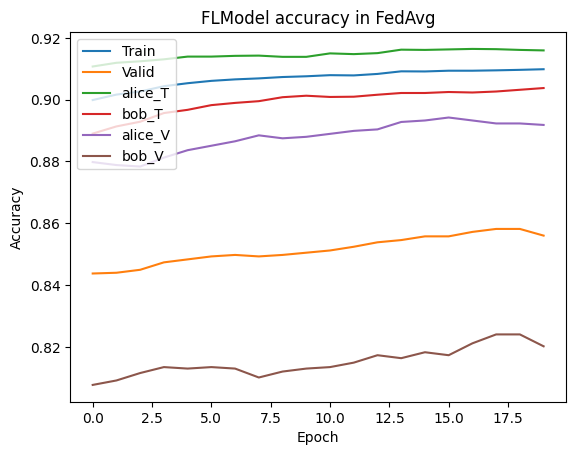

In [14]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history_2['global_history']['multiclassaccuracy'])
plt.plot(history_2['global_history']['val_multiclassaccuracy'])
plt.plot(history_2['local_history']['alice_train_multiclassaccuracy'])
plt.plot(history_2['local_history']['bob_train_multiclassaccuracy'])
plt.plot(history_2['local_history']['alice_val_eval_multiclassaccuracy'])
plt.plot(history_2['local_history']['bob_val_eval_multiclassaccuracy'])
plt.title('FLModel accuracy in FedAvg')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid','alice_T','bob_T','alice_V','bob_V'], loc='upper left')
plt.show()